### Custom ML model to identify local similarities ("links") with sequence profiles

Let $$X \in \{0,1\}^{B\times N\times 6 \times T \times 21}$$ be a batch of **one-hot encoded input translated sequences**,
where $B$ is `batch_size`, $N$ is the number of genomes and $T$ is the `tile_size` (in aa).
The 6 is here the number of translated frames in order (0,+),(1,+),(2,+),(0,-),(1,-),(2,-).
The 22 is here the size of the considered amino acid alphabet.


In [1]:
import numpy as np
import tensorflow as tf
import logomaker
from time import time
from IPython.display import Audio

import importlib
import sequtils as su
print(importlib.reload(su))
import seq
print(importlib.reload(seq))

<module 'sequtils' from '/home/matthis/genomegraph/learn_specific_profiles/sequtils.py'>
<module 'seq' from '/home/matthis/genomegraph/learn_specific_profiles/seq.py'>


### Create random genomes as toy data 

In [2]:
N = 8            # number of genomes
tile_size = 334  # tile size measured in amino acids
# A tile is a consecutive subsequence of _one_ contig/scaffold/chromosome.
# Tiles should be about gene-sized.

#genome_sizes = [[210,100], [30,220,150], [230,110,120,90], [180]] # in nucleotides
#insertPatterns = ["ATGATGATG", "CCCCCCCCCCCC"]
#genomes = seq.getRandomGenomes(N, genome_sizes, insertPatterns, mutationProb=0.2, verbose=True)

genome_sizes = [[1000]] * 8
                # in nucleotides
insertPatterns = ["ATGGCAAGAATTCAATCTACTGCAAATAAAGAA",
                 ] 
repeatPatterns = None #['AGAGAACCTGAAGCTACTGCTGAACCTGAAAGA']
genomes = seq.getRandomGenomes(N, genome_sizes, insertPatterns,
                               #repeatPatterns,
                               mutationProb=0.1, verbose=True)

Pattern ATGGCAAGAATTCAATCTACTGCAAATAAAGAA translates to  ['MARIQSTANKE', 'WQEFNLLQIK', 'GKNSIYCK*R', 'FFICSRLNSCH', 'SLFAVD*ILA', 'LYLQ*IEFLP']
  mutated to ATGGCAAGAATTCAATCTACTGCAAATAAAGAA and inserted in genome 0 contig 0 at position 681
  mutated to ATGGCCAGAATCCAATCTACTGCAAATAAGGAA and inserted in genome 1 contig 0 at position 110
  mutated to ATAGCAAGAATCCAATCTACTGCAAAAAAAGAA and inserted in genome 2 contig 0 at position 647
  mutated to ATGGCGAGAATTCAATCTACAGCCAATAAAGAC and inserted in genome 3 contig 0 at position 239
  mutated to ATGGCAAGAATTCAATCTACCGCAAATAAAGAA and inserted in genome 4 contig 0 at position 38
  mutated to ATGGCAAGAATCCAATCCACTGCAAATAAAGAA and inserted in genome 5 contig 0 at position 455
  mutated to ATGGCAAGAATTCACTCTACCGCAAATAAAGAA and inserted in genome 6 contig 0 at position 314
  mutated to ATGGCAAGAATTCAATCTACCGCAAATAAAGAA and inserted in genome 7 contig 0 at position 146


In [3]:
if insertPatterns is not None:
    desiredPatternAA = []
    for pattern in insertPatterns:
        desiredPatternAA.extend(su.six_frame_translation(pattern))
    
    print("Desired:", desiredPatternAA)
    
if repeatPatterns is not None:
    repeatPatternAA = []
    for pattern in repeatPatterns:
        repeatPatternAA.extend(su.six_frame_translation(pattern))

    print("Repeat:", repeatPatternAA)

Desired: ['MARIQSTANKE', 'WQEFNLLQIK', 'GKNSIYCK*R', 'FFICSRLNSCH', 'SLFAVD*ILA', 'LYLQ*IEFLP']


---

#### Interlude: Magic Commands

https://towardsdatascience.com/speed-up-jupyter-notebooks-20716cbe2025

`%time command` prints runtime of command  
`%prun command` profiler for command, what steps take how much time? Adds overhead  
`%memit command` peak memory usage and memory increment  
`%mprun command` memory profiling

---

In [4]:
# Load Real Data
if True:
    from Bio import SeqIO
    import os
    %load_ext memory_profiler
    
    files = ['hg38.fa', 'mm10.fa', 'hetGla2.fa', 'macFas5.fa']
    genomes = [[] for _ in range(len(files))]
    datapath = "/nas-hs/projs/seedFinding/data/20210517_flanked/"
    def loadRealGenomes(genomes=genomes):
        for i in range(len(files)):
            genomes[i].extend([str(seq.seq) for seq in SeqIO.parse(os.path.join(datapath, files[i]), 'fasta')])
            
    %memit loadRealGenomes()

peak memory: 751.30 MiB, increment: 436.63 MiB


In [5]:
len(genomes[0])

1410

In [6]:
# background distribution observed in the data 
%time Q = seq.backGroundAAFreqs(genomes, True)

# uniform background distribution appears to be rather better
#Q = np.ones(21, dtype=np.float32)/21

background freqs:  765611260.0 *
C 0.0329
K 0.0412
E 0.0332
W 0.0165
T 0.0578
G 0.0558
Y 0.0334
A 0.0510
I 0.0546
N 0.0361
V 0.0578
H 0.0321
S 0.0929
D 0.0280
F 0.0406
M 0.0172
R 0.0710
L 0.1039
P 0.0558
Q 0.0352
* 0.0527
CPU times: user 7min 18s, sys: 1.74 s, total: 7min 20s
Wall time: 7min 20s


#### Read in the genome

In [7]:
maxGenomeLen = max([sum([len(s) for s in genome]) for genome in genomes])
print(maxGenomeLen)

124695686


In [8]:
# batch_size = 1  # number of tile per batch, constrained by RAM and gradient descent performance
# batch_size = np.math.ceil(maxGenomeLen/(3 * tile_size + 2)) # 124199, OOM on greifserv3 (need 78 GB)
batch_size = 5000
print(batch_size)

%time %memit X = seq.getNextBatch(genomes, batch_size, tile_size, verbose=False)
X.shape

5000
peak memory: 3983.91 MiB, increment: 3194.39 MiB
CPU times: user 20 s, sys: 804 ms, total: 20.8 s
Wall time: 20.9 s


(5000, 4, 6, 334, 21)

In [9]:
def plotLogo(P, idxarray = None, pScores = None, max_print=5):
    """
    max_print  print up to this many logos
    """
    dfs = su.makeDFs(P.numpy())
    for i in range(min(U,max_print)):
        j = idxarray[i] if idxarray is not None else i
        profile_df = dfs[j]
        logo = logomaker.Logo(profile_df, vpad=.1, width=1)
        logo.style_xticks(anchor=0, spacing=1, rotation=45)
        logo.ax.set_ylabel('information (bits)')
        logo.ax.set_title(f"Profile {j}" + (f" score={pScores[j]:.1f}") if pScores is not None else "")

## TensorFlow Model
Let $$P = (P[w,c,u]) \in [0,1]^{k \times 21 \times U}$$
be a collection of $U$ amino acid **profiles**, each of length $k$.
Let $$ Q = (Q[c]) \in [0,1]^{21}$$ be a background amino acid distribution.

Both are normalized distributions:
$$ \sum_c P[w,c,u] = \sum_c Q[c] = 1 \qquad \forall u,w.$$

Define the scores tensor 
$$ S \in \mathbb{R}^ {B\times N \times U}$$
by
$$ S[b,g,u] = \max_{f=0}^5 \max_{v=0}^{T-k} \sum_{w=0}^{k-1} \sum_{c=0}^{20} X[b,g,f,v+w,c] \cdot \ln \frac {P[w,c,u]}{Q[c]}.$$

For a given batch $S[b,g,u]$ is the maximal score that the $u$-th profile scores in the $b$-th tile of genome $g$.
It can be computed using a **one dimensional convolution** and max pooling.

Define the intermediate variables:

$R \in [0,1]^{k \times 21 \times U}$ by 
$$ R[w,c,u] := \ln \frac {P[w,c,u]}{Q[c]}.$$

$Z \in \mathbb{R}^{B\times N \times 6 \times T-k-1\times U}$ by
$$Z[b,g,f,v,u] := \sum_{w=0}^{k-1} \sum_{c=0}^{20} X[b,g,f,v+w,c] \cdot R[w,c,u].$$

**Losses:**
Only the best score counts for each frame and tile. Sum them up.
$$L_1 = - \sum_{b=1}^B \sum_{g=1}^G \sum_{u=1}^U S[b,g,u]$$ 

In [10]:
U = 100 # number of profiles to train
k = 11 # length of profiles

In [11]:
class SpecificProfile(tf.keras.Model):
    def __init__(self, k, alphabet_size, units, Q, **kwargs):
        super().__init__(**kwargs)
        # P_logit_init = tf.random.normal([k, alphabet_size, units], stddev=.5, dtype=tf.float32, seed=1)
        
        #np.random.seed(1)
        
        P_logit_init = np.random.normal(scale=.5, size=[k, alphabet_size, units]).astype('float32')
        #P_logit_init[4,19,:] = 5 # Q
        #P_logit_init[5,12,:] = 5 # S
        #P_logit_init[6,4,:] = 5 # T
        if False: # to test whether the right pattern has low loss
            P_logit_init = -100 *np.ones([k, 21, units], dtype=np.float32)
            P_logit_init[0,15,:] = 5 # M
            P_logit_init[1,7,:] = 5 # A
            P_logit_init[2,16,:] = 5 # R
            P_logit_init[3,8,:] = 5 # I
            P_logit_init[4,19,:] = 5 # Q
            P_logit_init[5,12,:] = 5 # S
            P_logit_init[6,4,:] = 5 # T
            P_logit_init[7,7,:] = 5 # A
            P_logit_init[8,9,:] = 5 # N
            P_logit_init[9,1,:] = 5 # K
            P_logit_init[10,2,:] = 5 # E

        self.P_logit = tf.Variable(P_logit_init, trainable=True, name="P_logit") 
        self.Q = Q
        self.k = k
        self.alphabet_size = alphabet_size
        self.units = units

    def getP(self):
        # P1_logit = -1000 * tf.ones([self.k, 1, self.units])
        # P2_logit = tf.stack([P1_logit, self.P_logit], axis=1)
        P = tf.nn.softmax(self.P_logit, axis=1, name="P")
        return P
    
    def call(self, X):
        P = self.getP()
        Q1 = tf.expand_dims(self.Q,0)
        Q2 = tf.expand_dims(Q1,-1)
        # Limit the odds-ratio, to prevent problemt with log(0).
        # Very bad matches of profiles are irrelevant anyways.
        ratio = tf.maximum(P/Q2, 1e-6)
        R = tf.math.log(ratio)

        X1 = tf.expand_dims(X,-1) # 1 input channel
        R1 = tf.expand_dims(R,-2) # 1 input channel
        Z1 = tf.nn.conv2d(X1, R1, strides=1,
                          padding='VALID', data_format="NHWC", name="Z")
        Z = tf.squeeze(Z1, 4) # remove input channel dimension

        S = tf.reduce_max(Z, axis=[2,3])
        return S, R

    # custom loss
    def loss(self, S):
        # overall fit of patterns
        L1 = -tf.reduce_sum(S)
        # L1 = -tf.reduce_sum(tf.reduce_max(S, axis=[0,2]))
        
        # homogeneity along pattern
        P = self.getP()
        H = -tf.reduce_sum(tf.math.multiply(P, tf.math.log(P)), axis=1) # entropy
        # standard deviation of entropies
        VH = tf.math.reduce_std(H, axis=0) # variance for each profile along site axis
        L2 = tf.reduce_mean(VH)
        
        # homogeneity between genomes
        # ignore the best score per genome, so that rather others are improved
        L3 = tf.reduce_sum(tf.reduce_max(S, axis=1)) # cancels out the best occurence from L1
        
        # other ideas: 
        # - std deviation of scores of different genomes
        L4 = tf.reduce_sum(tf.math.reduce_std(tf.reduce_max(S, axis=0), axis=0))
        # - minimum score of any genome
        
        #return (L1+L3)/N + 50*L2, L2, L4 # + 100*L2 # (L1 + L3)/N #+ 100*L2
        return L1, L2, L4 # + 100*L2

    @tf.function()
    def train_step(self, X):
        with tf.GradientTape() as tape:
            S, _ = self.call(X)
            L, _, _ = self.loss(S)

        grad = tape.gradient(L, self.P_logit)
        self.opt.apply_gradients([(grad, self.P_logit)])

    def train(self, X, epochs=1000, verbose=True):
        self.opt = tf.keras.optimizers.Adam(learning_rate=.1) # large learning rate is much faster
        for i in range(epochs):
            self.train_step(X)
            if verbose and (i%(100) == 0 or i==epochs-1):
                S, R = self(X)
                L, _, _ = self.loss(S)
                print(f"epoch {i:>5} loss={L.numpy():.4f}" +
                      " max R: {:.3f}".format(tf.reduce_max(R).numpy()) +
                      " min R: {:.3f}".format((tf.reduce_min(R).numpy())))

In [12]:
tf.keras.backend.clear_session() # avoid memory cluttering by remains of old models

In [13]:
# build and randomly initialize profile model
%time %memit specProModel = SpecificProfile(k, su.aa_alphabet_size, U, Q)

peak memory: 3989.29 MiB, increment: 4.59 MiB
CPU times: user 188 ms, sys: 252 ms, total: 440 ms
Wall time: 676 ms


In [14]:
if False:
    P_init = specProModel.getP()
    plotLogo(P_init)

### Training

In [15]:
start = time()
%time %memit specProModel.train(X, epochs=500)
end = time()
print(f"time: {end-start:.2f}")
#Audio("/home/mario/audio/fertig.mp3", autoplay=True)

epoch     0 loss=-9973826.0000 max R: 2.662 min R: -2.619
epoch   100 loss=-14088566.0000 max R: 2.785 min R: -7.772
epoch   200 loss=-14184339.0000 max R: 2.876 min R: -9.914
epoch   300 loss=-14205027.0000 max R: 2.844 min R: -10.537
epoch   400 loss=-14212139.0000 max R: 2.851 min R: -11.057
epoch   499 loss=-14215394.0000 max R: 2.851 min R: -11.413
peak memory: 26064.53 MiB, increment: 22075.20 MiB
CPU times: user 1d 22h 52min 31s, sys: 2h 50min 17s, total: 2d 1h 42min 48s
Wall time: 2h 31min 20s
time: 9080.84


In [16]:
S, R = specProModel(X)
L1, L2, L4 = specProModel.loss(S)
pScores = tf.reduce_sum(tf.reduce_max(S,axis=0), axis=0).numpy()
print("pScores", pScores)
np.argsort(pScores)
print ("loss=", L1.numpy(), "\tL2=", L2.numpy(), 
       "\tL4=", L4.numpy(), "\nS=", S.numpy())
#print ("R", R.numpy())

pScores [59.593056 58.0521   59.587273 59.99071  59.70953  56.60943  59.923954
 56.853786 57.864185 59.08495  59.47583  60.212044 59.955734 58.339577
 55.983086 56.832817 59.25219  58.304573 57.94711  61.586807 57.573925
 60.760353 58.10826  57.911278 57.637978 58.535988 58.38751  57.630085
 59.162983 59.11468  59.41347  58.298378 59.222828 59.787346 57.187126
 58.746403 59.621456 59.547714 58.505177 57.816334 60.23147  60.47371
 59.994244 57.863335 58.836082 58.38858  59.15389  57.801464 59.130573
 57.525032 58.649544 59.437683 58.259747 60.614468 57.482124 58.90062
 57.866806 58.338932 57.3547   58.484314 59.203377 57.76781  60.361103
 58.79789  59.668648 57.478813 59.789906 57.560337 60.78519  58.162476
 56.61348  58.81221  59.50465  58.304306 58.556175 58.605537 57.563583
 61.6257   58.836395 59.154716 58.876484 58.467716 60.172558 56.27749
 58.527237 57.69896  59.03228  58.494537 59.699867 58.141514 59.859303
 57.76339  59.14405  57.741825 60.523815 57.261627 56.923088 59.18399
 5

### Visualize resulting profiles as sequence logos

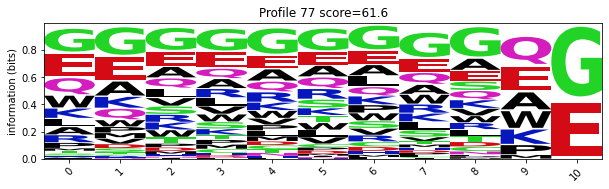

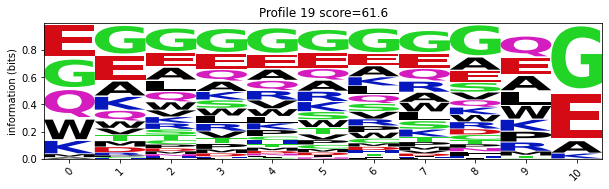

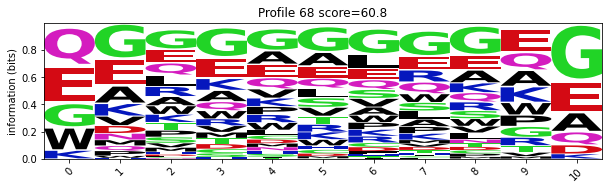

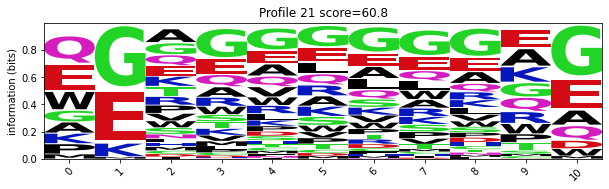

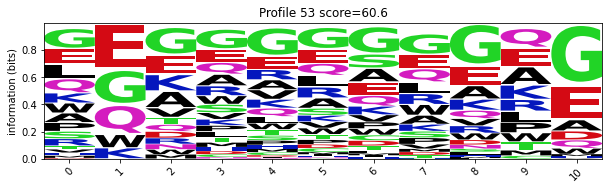

In [17]:
P = specProModel.getP()
plotLogo(P=P, idxarray = np.argsort(-pScores), pScores=pScores, max_print=5)
# should be similar to one of ['MARIQSTANKE', 'WQEFNLLQIK', 'GKNSIYCK*R', 'FFICSRLNSCH', 'SLFAVD*ILA', 'LYLQ*IEFLP']
# Repeats: ['REPEATAEPER', 'ENLKLLLNLK', 'RT*SYC*T*K', 'SFRFSSSFRFS', 'LSGSAVASGS', 'FQVQQ*LQVL']

In [18]:
# dataset = tf.data.Dataset.from_tensor_slices([X])

---

## Profile Score Distribution

In [19]:
P.shape

TensorShape([11, 21, 100])

In [20]:
R.shape

TensorShape([11, 21, 100])

In [21]:
X.shape

(5000, 4, 6, 334, 21)

In [22]:
np.array(R).max()

2.8507388

In [23]:
minscore = np.array(R).min() * specProModel.k # profile matches not at all
maxscore = np.array(R).max() * specProModel.k # all bases match perfectly
print(minscore, ",", maxscore)
minscore = np.math.floor(minscore)
maxscore = np.math.floor(maxscore)

-125.54307460784912 , 31.358126401901245


In [24]:
# R.shape [11, 21, 100]
# X.shape (1, 5640, 6, 334, 21)
scoreBins = dict([(b,0) for b in range(minscore, maxscore)])
print(scoreBins)
assert k == R.shape[0]

#X1 = tf.expand_dims(X,-1) # 1 input channel
#R1 = tf.expand_dims(R,-2) # 1 input channel
#Z1 = tf.nn.conv2d(X1, R1, strides=1,
#                  padding='VALID', data_format="NHWC", name="Z")
#Z = tf.squeeze(Z1, 4) # remove input channel dimension
#
#S = tf.reduce_max(Z, axis=[2,3])

for pidx in range(R.shape[2]):
    profile = R[:,:,pidx]
    for seqidx in range(X.shape[1]):
        for frame in range(X.shape[2]):
            for i in range(0, X.shape[3]-k+1):
                kmer = X[0,seqidx,frame,range(i,i+k),:]
                assert kmer.shape == profile.shape, str(kmer.shape)+" != "+str(profile.shape)
                score = np.math.floor(sum(np.array(kmer*profile).flatten()))
                assert score in scoreBins, str(score)
                scoreBins[score] += 1

{-126: 0, -125: 0, -124: 0, -123: 0, -122: 0, -121: 0, -120: 0, -119: 0, -118: 0, -117: 0, -116: 0, -115: 0, -114: 0, -113: 0, -112: 0, -111: 0, -110: 0, -109: 0, -108: 0, -107: 0, -106: 0, -105: 0, -104: 0, -103: 0, -102: 0, -101: 0, -100: 0, -99: 0, -98: 0, -97: 0, -96: 0, -95: 0, -94: 0, -93: 0, -92: 0, -91: 0, -90: 0, -89: 0, -88: 0, -87: 0, -86: 0, -85: 0, -84: 0, -83: 0, -82: 0, -81: 0, -80: 0, -79: 0, -78: 0, -77: 0, -76: 0, -75: 0, -74: 0, -73: 0, -72: 0, -71: 0, -70: 0, -69: 0, -68: 0, -67: 0, -66: 0, -65: 0, -64: 0, -63: 0, -62: 0, -61: 0, -60: 0, -59: 0, -58: 0, -57: 0, -56: 0, -55: 0, -54: 0, -53: 0, -52: 0, -51: 0, -50: 0, -49: 0, -48: 0, -47: 0, -46: 0, -45: 0, -44: 0, -43: 0, -42: 0, -41: 0, -40: 0, -39: 0, -38: 0, -37: 0, -36: 0, -35: 0, -34: 0, -33: 0, -32: 0, -31: 0, -30: 0, -29: 0, -28: 0, -27: 0, -26: 0, -25: 0, -24: 0, -23: 0, -22: 0, -21: 0, -20: 0, -19: 0, -18: 0, -17: 0, -16: 0, -15: 0, -14: 0, -13: 0, -12: 0, -11: 0, -10: 0, -9: 0, -8: 0, -7: 0, -6: 0, -5: 0, -

(array([16., 16., 15., 16., 15., 16., 16., 15., 16., 16.]),
 array([-126. , -110.4,  -94.8,  -79.2,  -63.6,  -48. ,  -32.4,  -16.8,
          -1.2,   14.4,   30. ]),
 <BarContainer object of 10 artists>)

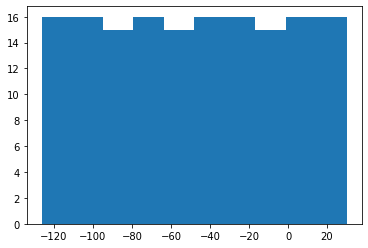

In [25]:
import matplotlib.pyplot as plt

plt.hist(scoreBins)

---

Idea: 
* convert profiles into aa-sequences (translate max. values into aa at each position)
* align (or perfect match?) sequences against the 6 possible pattern translations and the insert translations
* alignment scores give an idea of how good the profiles are -> allows multiple training runs to account for randomness, evaluate how good the profiles usually are (+ variance)

In [ ]:
from Bio import pairwise2
from Bio.pairwise2 import format_alignment

In [ ]:
def runTraining():
    tf.keras.backend.clear_session() # avoid memory cluttering by remains of old models
    
    # build and randomly initialize profile model
    specProModel = SpecificProfile(k, su.aa_alphabet_size, U, Q)
    
    #start = time()
    specProModel.train(X, epochs=500, verbose=False)
    #end = time()
    #print(f"time: {end-start:.2f}")
    
    #S, R = specProModel(X)
    #L1, L2, L4 = specProModel.loss(S)
    #pScores = tf.reduce_sum(tf.reduce_max(S,axis=0), axis=0).numpy()
    #print("pScores", pScores)
    #np.argsort(pScores)
    #print ("loss=", L1.numpy(), "\tL2=", L2.numpy(), 
    #       "\tL4=", L4.numpy(), "\nS=", S.numpy())
    
    P = specProModel.getP()
    
    return P

In [ ]:
def aaFromProfiles(P):
    profiles_aa = []
    for pidx in range(P.shape[2]):
        pmat = P[:,:,pidx]
        profiles_aa.append(su.to_aa_seq(pmat))

    return profiles_aa

In [ ]:
def getBestAlignments(profiles, patterns, scoreThreshold = int(k/2)):
    scores = []
    alignments = []
    best_profiles = []
    for profile in profiles:
        pscores = []
        palignments = []
        for pattern in patterns:
            als = pairwise2.align.localxd(profile, pattern, openA=-1000, extendA=-1000, openB=-1000, extendB=-1000)
            s = [al.score for al in als]
            if len(s) > 0:
                pscores.append(np.argmax(s))
                palignments.append(als[np.argmax(s)])

        best_al = palignments[np.argmax(pscores)]
        if best_al.score >= scoreThreshold:
            scores.append(best_al.score)
            alignments.append(best_al)
            best_profiles.append(profile)

    if len(scores) > 0:
        sortedIdx = np.argsort([-s for s in scores])
        scores = [scores[i] for i in sortedIdx]
        alignments = [alignments[i] for i in sortedIdx]
        best_profiles = [best_profiles[i] for i in sortedIdx]
    
    return scores, alignments, best_profiles

In [ ]:
for i in range(20):
    P = runTraining()
    profiles = aaFromProfiles(P)
    print("Run", i)
    print("Desired profiles:")
    patternScores, patternAlignments, patternProfiles = getBestAlignments(profiles, desiredPatternAA)
    for i in range(len(patternScores)):
            print(patternProfiles[i])
            print(format_alignment(*(patternAlignments[i])))
            
    #print("Undesired profiles:")
    #repeatScores, repeatAlignments, repeatProfiles = getBestAlignments(profiles, repeatPatternAA)
    #for i in range(len(repeatScores)):
    #        print(repeatProfiles[i])
    #        print(format_alignment(*(repeatAlignments[i])))
            
    print("")
    print("-----")
    print("")

In [ ]:
np.random.seed()
P = runTraining()
profiles = aaFromProfiles(P)
print("Desired profiles:")
patternScores, patternAlignments, patternProfiles = getBestAlignments(profiles, desiredPatternAA, scoreThreshold=4)
for i in range(len(patternScores)):
        print(patternProfiles[i])
        print(format_alignment(*(patternAlignments[i])))

In [ ]:
import sys

In [ ]:
from IPython.display import clear_output
for i in range(10):
    sys.stdout.write('\033[2K\033[1G')
    print("xxXXXxxXxxXxxxxxxxxxxxxxxXXxx", end='\r')
    clear_output()
    print(i,"/ 10", end='\r')
    #sys.stdout.write("\033[K")
    